In [84]:
import os,sys
sys.path.insert(0,'..')
from hdogreg.dataset import ImageDataset
from hdogreg.visualization import pil_from_array, generate_masked_image
from hdogreg.image import blob_detector_hdog, hybrid_approach
import torch
import numpy as np

In [31]:
img_dir = '../../../Data/INbreast-pytorch/images/png16/'
val_csv = 'cluster.csv'
img_name = '20587080_b6a4f750c6df4f90_MG_R_ML_ANON.png'
gpu_number = 0
model_path = '../models/FPNr10a1nh.pth'

In [100]:
# Set gpu
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_number)
device = 'cuda'

# 1. Load image
(To keep file small only a patch is being displayed)

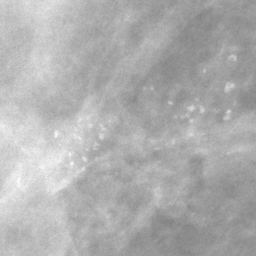

In [101]:
img_path = os.path.join(img_dir,img_name)
img = ImageDataset._img_to_numpy(None, img_path)
bb = (1920,1920+256,1910,1910+256)
img = img[bb[0]:bb[1],bb[2]:bb[3]]
display(pil_from_array(img))

# 2. Apply HDoG blob segmentation

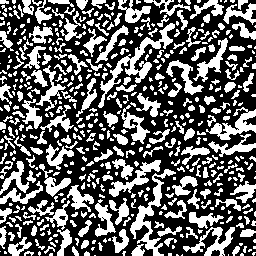

In [48]:
min_sigma = 1.18
max_sigma = 3.1
overlap = 1.
threshold = 0.006
hessian_thr = 1.4

blob_mask = blob_detector_hdog(img, 
                               min_sigma=min_sigma,
                               max_sigma=max_sigma, 
                               threshold=threshold, 
                               overlap=overlap, 
                               sigma_ratio=1.6,
                               hessian_thr=hessian_thr)
display(pil_from_array(blob_mask))

# 3. Infer with the regression model

In [102]:
model = torch.load(model_path).to(device)

In [103]:
x_tensor = torch.from_numpy((img-0.5)/0.5).to(device)
x_tensor = x_tensor.unsqueeze(0).unsqueeze(0).to(torch.float32)
out = model.predict(x_tensor).squeeze().cpu().numpy()

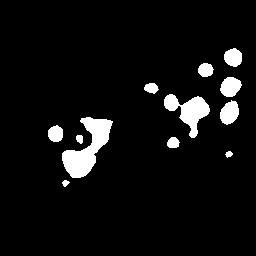

In [104]:
fpn_mask = out>0.5
pil_from_array(fpn_mask)

# 4. Combine to get final segmentation

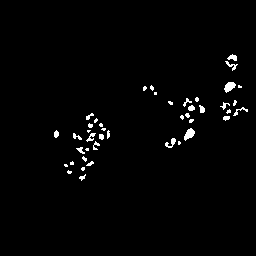

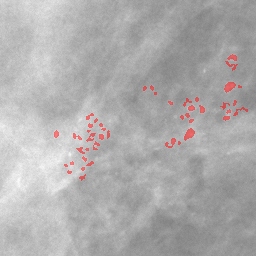

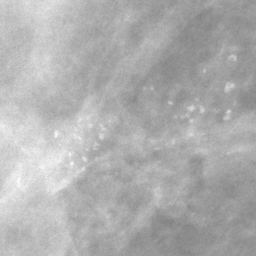

In [106]:
final_mask = hybrid_approach(pred_mask=fpn_mask,
                breast_mask=np.ones_like(fpn_mask),
                blob_mask=blob_mask,
                hybrid_combining='overlap', 
                hybrid_combining_overlap=0.3)
display(pil_from_array(final_mask))
pil_msk = generate_masked_image(img,[final_mask],[(255,0,0)],[0.5])
display(pil_msk)
display(pil_from_array(img))